In [ ]:
from pathlib import Path

#parent_folder = (r'/Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3/')
#parent_folder = (r'/Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/sarcomere_training/badv2')

bad_data_folder = (r'/Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/sarcomere_training/badv2')
good_data_folder = (r'/Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/sarcomere_training/goodv1')


parent_folder = (r'/Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/New_DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3_analysis')

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
from tifffile import imread, imwrite
from sarcasm import *
from sarcasm.export import Export
import shutil
import builtins

# Save original print
original_print = builtins.print  

# Disable print
builtins.print = lambda *a, **k: None  


# --- set your input folder ---
input_dir = Path(parent_folder)


# --- loop over all tif/TIF files ---
for f in sorted(input_dir.glob("*.tif")) + sorted(input_dir.glob("*.TIF")):
    print(f"Processing {f.name}...")

    # Load structure
    sarc_obj = Structure(f,pixelsize=0.1699)
    # detect sarcomere Z-bands, M-bands, orientation, sarcomere mask and cell mask by deep learning
    sarc_obj.detect_sarcomeres(max_patch_size=(2048, 2048))
    sarc_obj.analyze_cell_mask()
    sarc_obj.analyze_z_bands()
    sarc_obj.analyze_sarcomere_vectors()
    sarc_obj.analyze_myofibrils()
    sarc_obj.analyze_sarcomere_domains()




    # Get full dictionary of features
    d = Export.get_structure_dict(sarc_obj)

    # Keep only scalar entries (avoid ragged arrays)
    clean = {}
    for k, v in d.items():
        try:
            arr = np.asarray(v)
            if arr.ndim == 0:  # scalar
                clean[k] = arr.item()
            elif arr.ndim == 1 and arr.size == 1:  # single-value array
                clean[k] = arr[0].item()
            # skip longer arrays
        except Exception:
            continue

    # Make DataFrame (one row of scalars)
    df = pd.DataFrame([clean])

    # Save as transposed table (key | value)
    out_xlsx = f.parent / f"{f.stem}_scalars.xlsx"
    df.T.to_excel(out_xlsx)

    print("  → saved:", out_xlsx)

# Restore print
builtins.print = original_print  


100%|██████████| 1/1 [00:00<00:00, 28.33it/s]


In [ ]:
from pathlib import Path
import pandas as pd
import shutil

# ============ USER EDITS ============
parent_folder = "/path/to/your/folder"   # <-- set this
input_dir = Path(parent_folder)
# ====================================

all_dfs = []

for file in input_dir.glob("*.*"):
    if file.suffix.lower() not in [".xls", ".xlsx"]:
        continue
    if "_platemap" in file.name:  # skip platemap for now
        continue
    try:
        # read excel, skip first row
        engine = "openpyxl" if file.suffix.lower() == ".xlsx" else "xlrd"
        df = pd.read_excel(file, header=None, skiprows=1, engine=engine)

        # Expecting 2 columns: col0 = keys, col1 = values
        df = df.iloc[:, :2]
        df = df.dropna(how="all")

        # Transpose to a single row with keys as columns
        df_t = df.set_index(0).T
        df_t["filename"] = file.stem

        all_dfs.append(df_t)

    except Exception as e:
        print(f"⚠️ Skipped {file.name}: {e}")

# Prepare output folder
out_dir = input_dir / "w3_analysis"
out_dir.mkdir(exist_ok=True)

# Combine everything
if all_dfs:
    combined = pd.concat(all_dfs, ignore_index=True)
    print(combined.head())

    # save combined file
    out_file = out_dir / "combined_output.xlsx"
    combined.to_excel(out_file, index=False)
    print(f"✅ Saved combined dataframe to {out_file}")

    # Copy platemap file if exists
    platemaps = list(input_dir.glob("*_platemap.xlsx"))
    if platemaps:
        platemap_file = platemaps[0]  # take first match
        dest_file = out_dir / platemap_file.name
        shutil.copy2(platemap_file, dest_file)
        print(f"📋 Copied platemap to {dest_file}")
    else:
        print("⚠️ No platemap file found in folder.")

else:
    print("No valid .xls/.xlsx files processed.")

0 axes pixelsize frametime n_stack timestamps  \
0   YX    0.1699       NaN       1        NaN   
1   YX    0.1699       NaN       1        NaN   
2   YX    0.1699       NaN       1        NaN   
3   YX    0.1699       NaN       1        NaN   
4   YX    0.1699       NaN       1        NaN   

0                               file_name  \
0       MC25DF10-11-12-40x_B04_s13_w3.TIF   
1       MC25DF10-11-12-40x_B02_s36_w3.TIF   
2  MC25DF10-11-12-40x-rowA_A12_s27_w3.TIF   
3       MC25DF10-11-12-40x_B02_s37_w3.TIF   
4       MC25DF10-11-12-40x_B04_s14_w3.TIF   

0                                          file_path time sarcasm_version  \
0  X:\2025\D-Disease Modeling Team\MC-Temp\2D_ibi...  NaN           0.3.0   
1  X:\2025\D-Disease Modeling Team\MC-Temp\2D_ibi...  NaN           0.3.0   
2  X:\2025\D-Disease Modeling Team\MC-Temp\2D_ibi...  NaN           0.4.0   
3  X:\2025\D-Disease Modeling Team\MC-Temp\2D_ibi...  NaN           0.3.0   
4  X:\2025\D-Disease Modeling Team\MC-Temp\2D_ibi

OriginalCode

In [2]:
from pathlib import Path
import pandas as pd

# ============ USER EDITS ============
input_dir = Path(parent_folder)
# ====================================

all_dfs = []

for file in input_dir.glob("*.*"):
    if file.suffix.lower() not in [".xls", ".xlsx"]:
        continue
    if "_platemap" in file.name:  # skip temp files
        continue
    try:
        # read excel, skip first row
        engine = "openpyxl" if file.suffix.lower() == ".xlsx" else "xlrd"
        df = pd.read_excel(file, header=None, skiprows=1, engine=engine)

        # Expecting 2 columns: col0 = keys, col1 = values
        df = df.iloc[:, :2]
        df = df.dropna(how="all")

        # Transpose to a single row with keys as columns
        df_t = df.set_index(0).T
        df_t["filename"] = file.stem

        all_dfs.append(df_t)

    except Exception as e:
        print(f"⚠️ Skipped {file.name}: {e}")

# Combine everything
if all_dfs:
    combined = pd.concat(all_dfs, ignore_index=True)
    print(combined.head())

    # save to Excel
    out_file = input_dir / "combined_output.xlsx"
    combined.to_excel(out_file, index=False)
    print(f"✅ Saved combined dataframe to {out_file}")
else:
    print("No valid .xls/.xlsx files processed.")

0 axes pixelsize frametime n_stack timestamps  \
0   YX    0.1699       NaN       1        NaN   
1   YX    0.1699       NaN       1        NaN   
2   YX    0.1699       NaN       1        NaN   
3   YX    0.1699       NaN       1        NaN   
4   YX    0.1699       NaN       1        NaN   

0                               file_name  \
0       MC25DF10-11-12-40x_B04_s13_w3.TIF   
1       MC25DF10-11-12-40x_B02_s36_w3.TIF   
2  MC25DF10-11-12-40x-rowA_A12_s27_w3.TIF   
3       MC25DF10-11-12-40x_B02_s37_w3.TIF   
4       MC25DF10-11-12-40x_B04_s14_w3.TIF   

0                                          file_path time sarcasm_version  \
0  X:\2025\D-Disease Modeling Team\MC-Temp\2D_ibi...  NaN           0.3.0   
1  X:\2025\D-Disease Modeling Team\MC-Temp\2D_ibi...  NaN           0.3.0   
2  X:\2025\D-Disease Modeling Team\MC-Temp\2D_ibi...  NaN           0.4.0   
3  X:\2025\D-Disease Modeling Team\MC-Temp\2D_ibi...  NaN           0.3.0   
4  X:\2025\D-Disease Modeling Team\MC-Temp\2D_ibi

prediction of good images

/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/MC25DF5-6a-6b-8_D06_s55_w4_scalars.xlsx
/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/SP25DC9-10-11_D10_s8_w4_scalars.xlsx
/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/SP25DC9-10-11_E05_s37_w4_scalars.xlsx
/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/SP25DC9-10-11_E05_s43_w4_scalars.xlsx
/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/SP25DC9-10-11_E05_s45_w4_scalars.xlsx
/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples/bad/SP25DC9-10-11_E05_s55_w4_scalars.xlsx
--- Provided Data Head ---
  class  pixelsize  n_stack  cell_mask_area  cell_mask_area_ratio  \
0  good     0.1699        1   118546.237084              0.979132   
0  good     0.1699        1   120879.678734              0.998405   
0  good     0.1699        1    59423.712516               0.49081   
0  good     0.1699        1    58704.602475               0.48487   
0  good     0.1699        1

/opt/anaconda3/envs/sarcasm/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/sarcasm/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sarcasm/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sarcasm/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


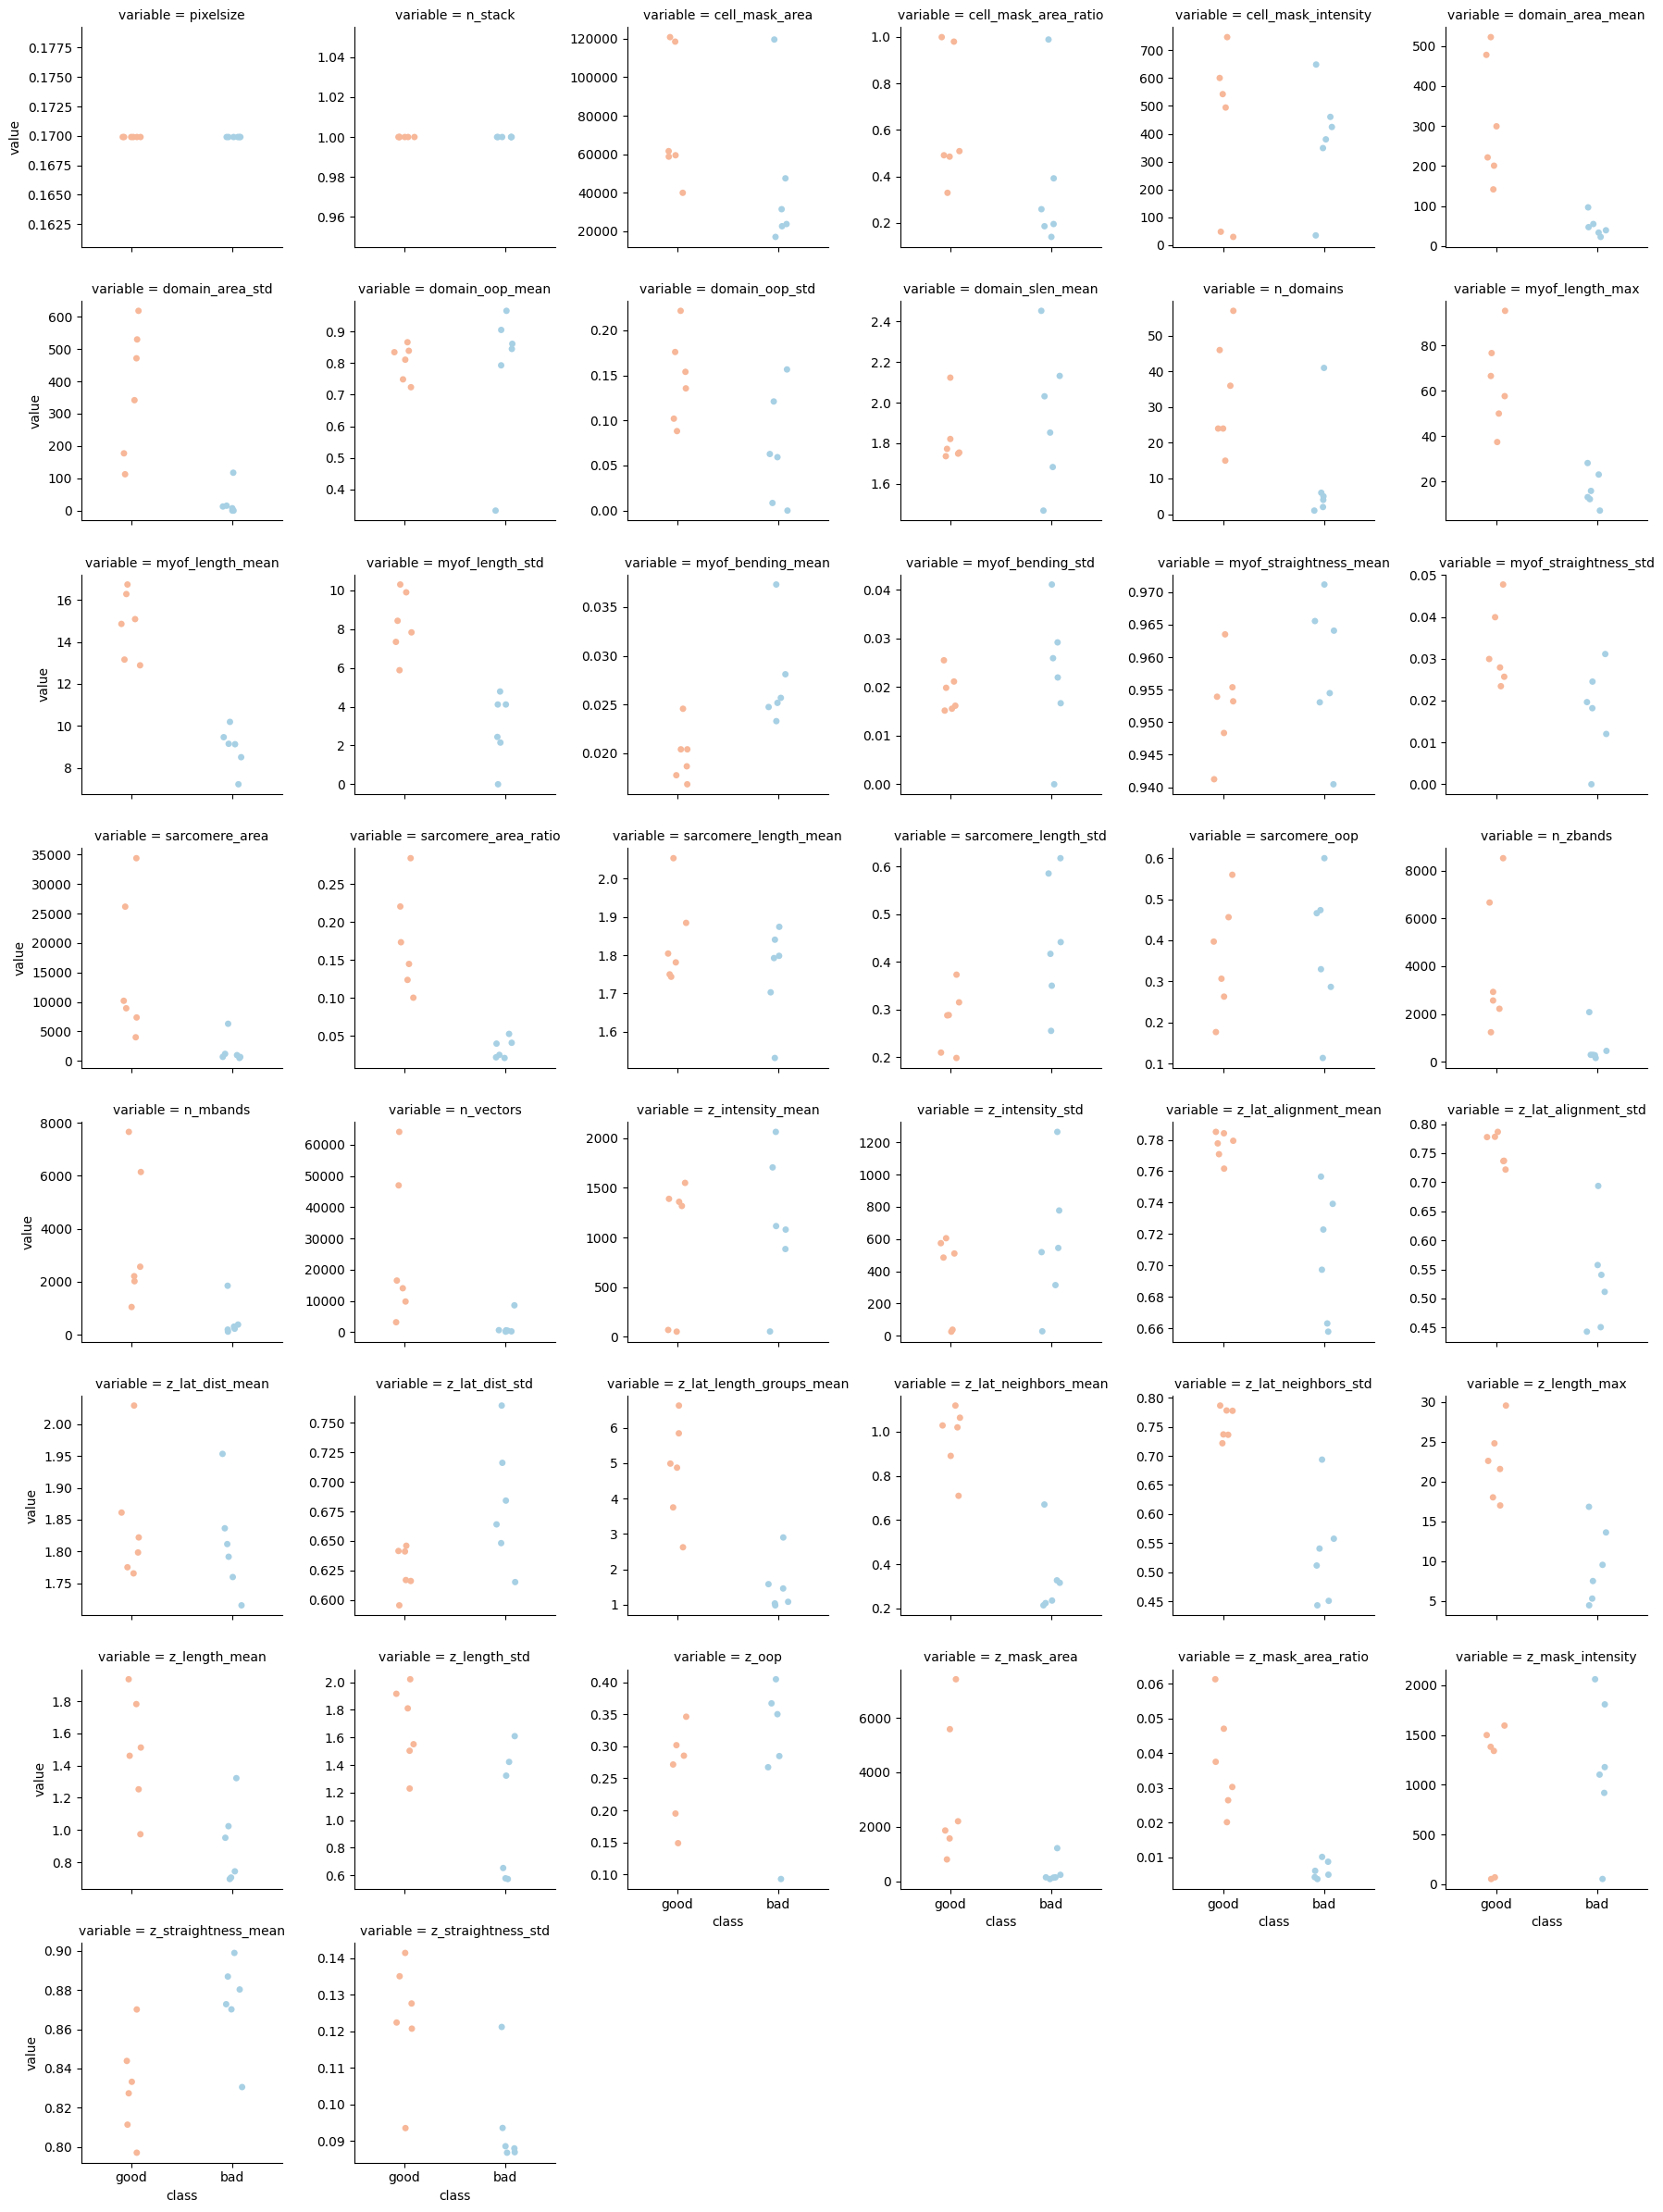

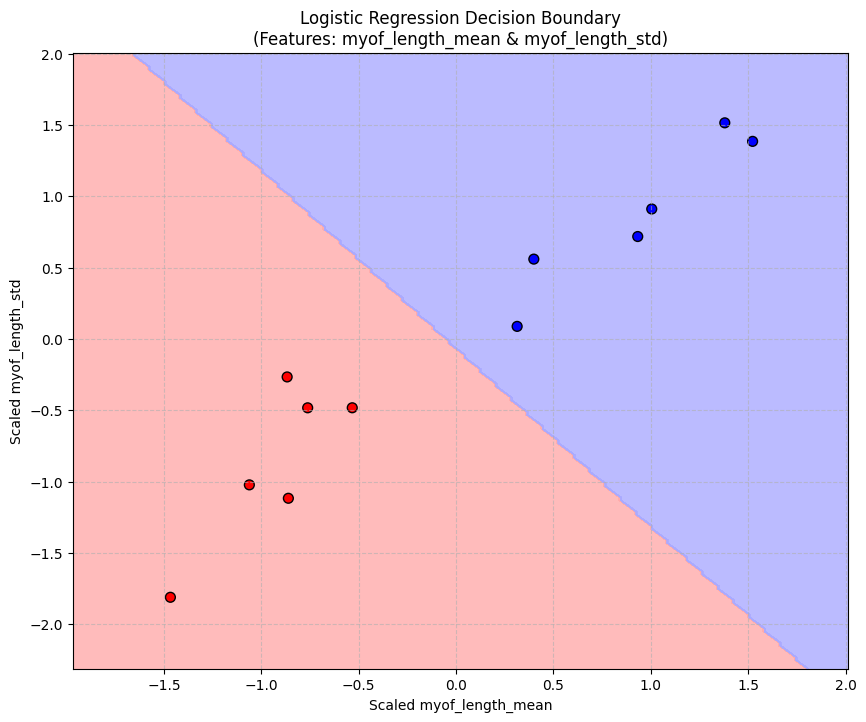

array([ 0.        , -0.07845544, -0.07845544,  0.19613364,  0.18212592,
        0.16376121, -0.01199843,  0.0429951 , -0.03267471,  0.03192952,
        0.24719922,  0.25863888,  0.25343285, -0.20936563, -0.07492468,
       -0.05804012,  0.06386891,  0.11408426,  0.22030012,  0.11083096,
       -0.10058537, -0.03031004,  0.11526523,  0.11623489,  0.10620754,
        0.12759728,  0.01360113,  0.15459436,  0.23991198,  0.08945421,
       -0.22253364,  0.19221393,  0.22706499,  0.23991198,  0.15338164,
        0.09752811,  0.10621864, -0.14837724,  0.12098563,  0.22836728,
        0.13476175, -0.06879888,  0.14538017])

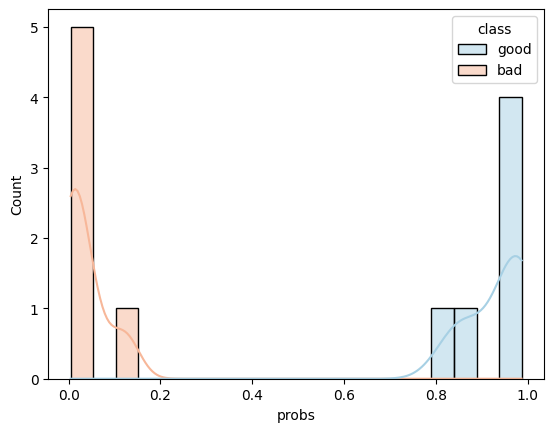

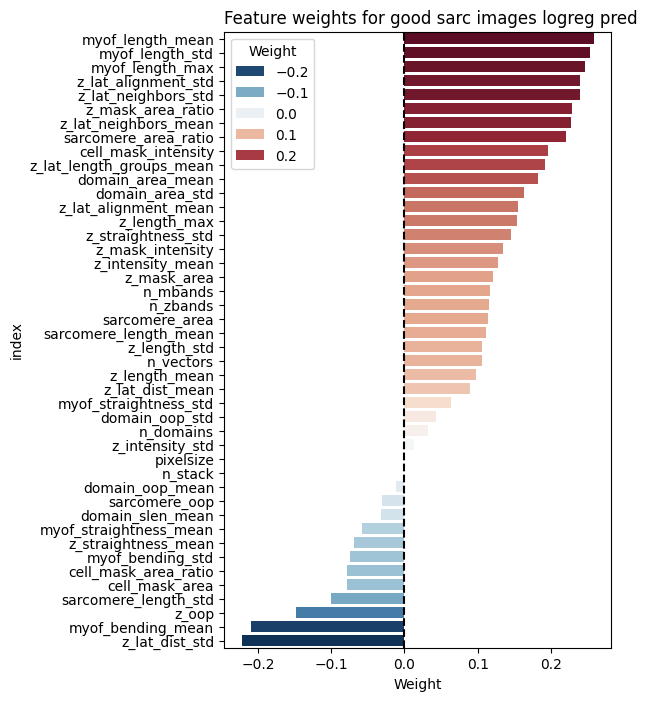

In [15]:
import os, sys, re
from pathlib import Path
import pandas as pd 
from natsort import natsorted
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
from tifffile import imread, imwrite
import shutil
import builtins

sarcomere_data = Path('/Volumes/volume2/2025/MC-Temporary/RvH-temp/Sarc_Examples')
good_data = natsorted(list((sarcomere_data/'good').iterdir()))
good_data = [x for x in good_data if 'DS_Store' not in x.name ]
good_data = [x for x in good_data if 'xlsx'  in x.name ]
good_sarc_features = pd.concat([pd.read_excel(file,index_col=0).T for file in good_data])
good_sarc_features['class'] = 'good'
good_sarc_features
bad_data = natsorted(list((sarcomere_data/'bad').iterdir()))
bad_data = [x for x in bad_data if 'DS_Store' not in x.name and r'~' not in x.name ]
bad_data = [x for x in bad_data if 'xlsx'  in x.name ]
bad_data


bad_sarc_features = pd.DataFrame()

for file in bad_data:
    print(file)
    f=  pd.read_excel(file,index_col=0).T
    bad_sarc_features = pd.concat([bad_sarc_features,f])
bad_sarc_features['class'] = 'bad'
bad_sarc_features
compare_df = pd.concat([good_sarc_features,bad_sarc_features])
compare_df
compare_df = compare_df.convert_dtypes()
numeric_cols = list(compare_df.dtypes.index[(compare_df.dtypes == 'Float64') | (compare_df.dtypes == 'Int64')])
numeric_cols
subset_df = compare_df.loc[:,['class'] + numeric_cols]
subset_df = subset_df.drop(columns=['frametime','timestamps','time','channel'])
plotdf = subset_df.melt(id_vars = 'class')

import matplotlib.pyplot as plt

g = sns.FacetGrid(plotdf, col='variable',col_wrap=6,sharey=False)
g.map_dataframe(sns.stripplot,x = 'class',y='value',hue='class',palette='RdBu')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib.colors import ListedColormap
def run_logistic_regression_analysis(df):
    """
    This function takes a DataFrame, performs a logistic regression classification workflow
    on unscaled data, including model training, weight inspection,
    and visualization of the decision boundary. The DataFrame is expected to have
    a 'class' column with 'good' and 'bad' values, and other numeric feature columns.
    """
    # 1. --- Initial Data Inspection ---
    print("--- Provided Data Head ---")
    print(df.head())
    print("\n--- Class Distribution ---")
    print(df['class'].value_counts())

    # 2. --- Data Preparation ---
    # Map target variable to numerical format
    df['class'] = df['class'].map({'good': 1, 'bad': 0})

    # Separate features (X) and target (y)
    X = df.drop('class', axis=1)
    y = df['class']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # 3. --- Build and Train the Model Pipeline ---
    # Create a pipeline that first scales the data and then fits the logistic regression model.
    # This is the correct way to handle scaling to prevent data leakage from the test set.
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42))
    ])

    # Train the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # 4. --- Evaluate the Model ---
    y_pred = pipeline.predict(X_test)
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred))

    print("\n--- Confusion Matrix ---")
    print(confusion_matrix(y_test, y_pred))

    # 5. --- Display Model Weights (Coefficients) ---
    # Access the logistic regression model and its coefficients from the pipeline
    model = pipeline.named_steps['logreg']
    coefficients = model.coef_[0]
    intercept = model.intercept_[0]

    # Create a DataFrame for better visualization of weights
    weights = pd.DataFrame(
        coefficients,
        index=X.columns,
        columns=['Weight']
    ).sort_values('Weight', ascending=False)

    print("\n--- Model Weights ---")
    print(weights)
    print(f"\nIntercept: {intercept:.4f}")

    # 6. --- Plot Decision Boundary ---
    # For visualization, we can only plot in 2D. We will use the two features
    # with the largest absolute weights.
    most_important_features = weights.abs().sort_values('Weight', ascending=False).index[:2]
    print(f"\nPlotting decision boundary for the two most important features: {most_important_features[0]} and {most_important_features[1]}")

    # Create a new pipeline with only the two selected features
    X_vis = df[most_important_features]
    y_vis = df['class']
    
    pipeline_vis = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(random_state=42))
    ])
    pipeline_vis.fit(X_vis, y_vis)

    # Create a mesh grid
    scaler_vis = pipeline_vis.named_steps['scaler']
    X_scaled_vis = scaler_vis.transform(X_vis)

    h = .02  # step size in the mesh
    x_min, x_max = X_scaled_vis[:, 0].min() - .5, X_scaled_vis[:, 0].max() + .5
    y_min, y_max = X_scaled_vis[:, 1].min() - .5, X_scaled_vis[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict on the mesh grid to get the decision boundary
    Z = pipeline_vis.predict(scaler_vis.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    # Plot
    plt.figure(figsize=(10, 8))
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF']) # Colors for background
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])   # Colors for points

    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

    # Plot the training points
    plt.scatter(X_scaled_vis[:, 0], X_scaled_vis[:, 1], c=y_vis, cmap=cmap_bold,
                edgecolor='k', s=50)
    
    plt.title(f'Logistic Regression Decision Boundary\n(Features: {most_important_features[0]} & {most_important_features[1]})')
    plt.xlabel(f'Scaled {most_important_features[0]}')
    plt.ylabel(f'Scaled {most_important_features[1]}')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    return pipeline
train_df = subset_df.__deepcopy__()
pipeline = run_logistic_regression_analysis(train_df)
pipeline
probs = pipeline.predict_proba(subset_df.iloc[:,1:])[:,1]
predict_df = subset_df.__deepcopy__()
predict_df['probs'] = probs

sns.histplot(predict_df,x='probs',hue='class',bins=20,kde=True,palette='RdBu_r')

model = pipeline.named_steps['logreg']
weights = pd.DataFrame(
        model.coef_[0],
        index=subset_df.columns[1:],
        columns=['Weight']
    ).sort_values('Weight', ascending=False)
weights= weights.reset_index(drop=False)
weights = weights
weights

fig, ax = plt.subplots(figsize=(5, 8))
sns.barplot(weights,x='Weight',y='index',hue='Weight',palette = 'RdBu_r')
plt.axvline(x=0,linestyle='--',color='black')
plt.title('Feature weights for good sarc images logreg pred',loc ='left')

model.coef_[0][1:]


In [16]:
parent_folder = '/Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/New_DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3_analysis'

In [ ]:
#predict_df = pd.read_excel('/Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3/combined_output.xlsx')
predict_df = pd.read_excel(Path(parent_folder) / "combined_output.xlsx")
def run_sarc_pred(sarc_features):
    sarc_features =sarc_features.reset_index(drop=True)
    sarc_features= sarc_features.loc[~pd.isna(sarc_features['domain_area_mean']),:]
    sarc_features= sarc_features.loc[~pd.isna(sarc_features['z_intensity_mean']),:]
    sarc_features = sarc_features.drop(columns=['frametime','timestamps','time','channel'])
    predict_df = sarc_features.loc[:,[x for x in train_df.columns if 'class' not in x]]
    sarc_features['class'] = pipeline.predict(predict_df)
    return sarc_features
predict_df = run_sarc_pred(predict_df)
predict_df['Well'] = [x[-3] for x in predict_df['file_name'].str.split('_')]


ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [31]:
print(predict_df['class'])

0       0
1       1
2       1
3       0
4       1
       ..
4272    0
4273    1
4274    0
4275    0
4276    0
Name: class, Length: 4277, dtype: int64


In [24]:
from pathlib import Path
import pandas as pd

# load input
predict_df = pd.read_excel(Path(parent_folder) / "combined_output.xlsx")

def run_sarc_pred(sarc_features):
    sarc_features = sarc_features.reset_index(drop=True)

    # drop columns you don’t want
    drop_cols = ['frametime', 'timestamps', 'time', 'channel']
    sarc_features = sarc_features.drop(columns=[c for c in drop_cols if c in sarc_features.columns])

    # keep only the columns that match the training features
    feature_cols = [x for x in train_df.columns if 'class' not in x]
    predict_df = sarc_features.loc[:, feature_cols]

    # drop rows with ANY NaN in the feature set
    mask = ~predict_df.isna().any(axis=1)
    sarc_features = sarc_features.loc[mask].copy()
    predict_df = predict_df.loc[mask]

    # run prediction
    sarc_features['class'] = pipeline.predict(predict_df)

    return sarc_features

predict_df = run_sarc_pred(predict_df)

# safer well extraction: use tokens not characters
predict_df['Well'] = predict_df['file_name'].str.split('_').str[-3]

/opt/anaconda3/envs/sarcasm/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sarcasm/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/opt/anaconda3/envs/sarcasm/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [26]:
# load your Excel file
#platemap_df = pd.read_excel( "/Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3/MCDF10-11-12_ibidi_HC_40x_platemap.xlsx")
# find platemap files

# find platemap files
platemap_files = list(Path(parent_folder).glob("*_platemap*.xlsx"))

if not platemap_files:
    raise FileNotFoundError(f"No platemap file found in {parent_folder}")

# pick the first (or loop if you expect multiple)
platemap_file = platemap_files[0]

print(f"Using platemap file: {platemap_file}")

# load into DataFrame
platemap_df = pd.read_excel(platemap_file)

# ensure Well column is string
platemap_df["Well"] = platemap_df["Well"].astype(str)

# pad numeric part to 2 digits
platemap_df["Well"] = platemap_df["Well"].str.replace(
    r"([A-Z])(\d+)", 
    lambda m: f"{m.group(1)}{m.group(2).zfill(2)}", 
    regex=True
)

#print(platemap_df["Well"].head())

#platemap_df
predict_df =predict_df.merge(platemap_df,on='Well',how='left')
for required_col in ['Condition','Treatment']:
    if required_col not in predict_df.columns:
        predict_df[required_col] = 'control'

Using platemap file: /Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/New_DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3_analysis/MCDF10-11-12_ibidi_HC_40x_platemap.xlsx


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --- SETTINGS ---
value_col = "sarcomere_length_mean"   # metric to plot
parent_folder = Path(parent_folder)   # ensure it's a Path, not str
plot_dir = parent_folder / "00_plots"
plot_dir.mkdir(parents=True, exist_ok=True)
# ----------------

# Drop placeholder rows
platemap_df = platemap_df[platemap_df["Cond"] != "x"].copy()

# Merge on Well (already aligned + padded)
merged = pd.merge(predict_df, platemap_df, on="Well", how="inner")

sns.set(style="whitegrid")

# Plot each BioRep separately
for bio in merged["BioRep"].dropna().unique():
    df_bio = merged[merged["BioRep"] == bio]
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_bio, x="Cond", y=value_col, hue="Treatment")
    plt.title(f"{bio} - {value_col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # save plot
    bio_safe = str(bio).replace(" ", "_")
    out_file = plot_dir / f"{bio_safe}_{value_col}.png"
    plt.savefig(out_file, dpi=300)
    print(f"✅ Saved {out_file}")
    
    plt.close()

# Combined plot (all BioReps together)
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x="Cond", y=value_col, hue="Treatment")
plt.title(f"All BioReps - {value_col}")
plt.xticks(rotation=45)
plt.tight_layout()

out_file = plot_dir / f"All_BioReps_{value_col}.png"
plt.savefig(out_file, dpi=300)
print(f"✅ Saved {out_file}")

plt.close()

# --- Export merged data to Excel ---
excel_out = plot_dir / "merged_data.xlsx"
merged.to_excel(excel_out, index=False)
print(f"✅ Exported merged data to {excel_out}")

MergeError: Passing 'suffixes' which cause duplicate columns {'Treatment_x'} is not allowed.

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

# --- SETTINGS ---
value_col = "sarcomere_length_mean"   # metric to plot
parent_folder = Path(parent_folder)   # ensure it's a Path, not str
plot_dir = parent_folder / "00_plots"
plot_dir.mkdir(parents=True, exist_ok=True)
# ----------------

# Drop placeholder rows from platemap
platemap_df = platemap_df[platemap_df["Cond"] != "x"].copy()

# --- Safe merge ---
# find overlapping columns (other than "Well")
common_cols = set(predict_df.columns).intersection(platemap_df.columns) - {"Well"}
if common_cols:
    print(f"⚠️ Dropping overlapping columns from predict_df: {common_cols}")
predict_df_clean = predict_df.drop(columns=list(common_cols))

# merge clean predictions with platemap metadata
merged = pd.merge(predict_df_clean, platemap_df, on="Well", how="inner")
print(f"✅ Merged data shape: {merged.shape}")

sns.set(style="whitegrid")

# --- Plot each BioRep separately ---
for bio in merged["BioRep"].dropna().unique():
    df_bio = merged[merged["BioRep"] == bio]
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_bio, x="Cond", y=value_col, hue="Treatment")
    plt.title(f"{bio} - {value_col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    out_file = plot_dir / f"{str(bio).replace(' ', '_')}_{value_col}.png"
    plt.savefig(out_file, dpi=300)
    print(f"✅ Saved {out_file}")
    plt.close()

# --- Combined plot (all BioReps together) ---
plt.figure(figsize=(10, 6))
sns.boxplot(data=merged, x="Cond", y=value_col, hue="Treatment")
plt.title(f"All BioReps - {value_col}")
plt.xticks(rotation=45)
plt.tight_layout()

out_file = plot_dir / f"All_BioReps_{value_col}.png"
plt.savefig(out_file, dpi=300)
print(f"✅ Saved {out_file}")
plt.close()

# --- Export merged data to Excel ---
excel_out = plot_dir / "merged_data.xlsx"
merged.to_excel(excel_out, index=False)
print(f"✅ Exported merged data to {excel_out}")

⚠️ Dropping overlapping columns from predict_df: {'Treatment'}
✅ Merged data shape: (2066, 62)
✅ Saved /Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/New_DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3_analysis/00_plots/DF10_sarcomere_length_mean.png
✅ Saved /Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/New_DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3_analysis/00_plots/DF11_sarcomere_length_mean.png
✅ Saved /Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/New_DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3_analysis/00_plots/DC12_sarcomere_length_mean.png
✅ Saved /Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/New_DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3_analysis/00_plots/DF14_sarcomere_length_mean.png
✅ Saved /Volumes/volume1/2025/D-Disease Modeling Team/MC-Temp/2D_ibidi_40x/New_DF10-11-12/MC25DF10-11-12-40x_Plate_22571/w3_analysis/00_plots/DF12_sarcomere_length_mean.png
✅ Saved /Volumes/volume1/2025/D-Disease 

### Plot

Lokeshs-MacBook-Pro.local
